### Imports

In [2]:
import torch
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio
import numpy as np
from torchvision import models, transforms

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F75BB06B-2723-344D-99CE-9CB8BB94077A> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Dataset class definition

In [3]:

class ImageDataset(Dataset):
    def __init__(self, image_dir, labels_df):
        self.image_dir = image_dir
        self.labels_df = labels_df

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.index[idx]
        img_path = os.path.join(self.image_dir, f"{img_name}.tif")

        # Open the TIF image using rasterio
        with rasterio.open(img_path) as src:
            # Read the image data
            image_data = src.read()
        image_array = np.array(image_data)
        image_tensor = torch.from_numpy(image_array)
        image_tensor = image_tensor.float()

        label = self.labels_df.iloc[idx, 0]

        return image_tensor, label



### Data preparation 

In [27]:
# image_dir = "/home/nadjaflechner/Palsa_data/dataset_100m/"
# labels_file = "/home/nadjaflechner/Palsa_data/binary_palsa_labels_100m.csv"

image_dir = "/Users/nadja/Documents/UU/Thesis/Data/100m"
labels_file = "/Users/nadja/Documents/UU/Thesis/Data/100m_palsa_labels.csv"

# Load the labels from the CSV file
labels_df = pd.read_csv(labels_file, index_col=0).head(100)

# Split the dataset into training and validation sets
train_df = labels_df.head(80)
val_df = labels_df.drop(train_df.index)

# Create the datasets and data loaders
train_dataset = ImageDataset(image_dir, train_df )
val_dataset = ImageDataset(image_dir, val_df )

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

### Loading EfficientNet model 

In [5]:
EfficientNet = models.efficientnet_b6(pretrained = True)

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B6_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B6_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
EfficientNet.classifier = nn.Sequential(
    nn.Linear(2304, 500, bias = True),  
    nn.ReLU(inplace=True),         
    nn.Dropout(0.5, inplace=False),               
    nn.Linear(in_features=500, out_features=500, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=500, out_features=200, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=200, out_features=2, bias=True)
)

# EfficientNet # to visually inspect model architecture

### Training/ finetuning

In [7]:
# freeze all convolutional layers
for param in EfficientNet.parameters():
    if isinstance(param, nn.Conv2d):
        param.requires_grad = False

# define model training parameters
model = EfficientNet
optimizer = optim.Adam(EfficientNet.parameters(), lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()
num_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define weights information 
weights = models.EfficientNet_B6_Weights.IMAGENET1K_V1
transforms = weights.transforms()

# Finetuning loop
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        transformed_batch = transforms(data)

        optimizer.zero_grad()
        
        outputs = model(transformed_batch)
        loss = loss_function(outputs, targets.long())
        loss.backward()
        optimizer.step()

        print(f"batch {batch_idx}/16 has been trained.")

        break


/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


batch 0/16 has been trained.


### Validation

In [18]:
model.eval()
weights = models.EfficientNet_B6_Weights.IMAGENET1K_V1
transforms = weights.transforms()

correct = 0
total = 0

for batch_idx, (data, targets) in enumerate(val_loader):
    data, targets = data.to(device), targets.to(device)
    transformed_batch = transforms(data)

    prediction = model(transformed_batch).softmax(1)
    class_scores, class_indices = torch.max(prediction, dim=1)

    total += targets.size(0)
    correct += (class_indices == targets).sum().item()

    break 

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation Accuracy: 50.00%


### Inference

In [6]:
EfficientNet.eval()
weights = models.EfficientNet_B6_Weights.IMAGENET1K_V1
transforms = weights.transforms()

for imgs, labels in train_loader:
    first_batch = imgs
    first_labels = labels
    break

transformed_batch = transforms(first_batch)

prediction = EfficientNet(transformed_batch).softmax(1)
class_scores, class_indices = torch.max(prediction, dim=1)

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### CAM experimentation 

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load the pretrained EfficientNet_b6 model
EfficientNet = models.efficientnet_b6(pretrained=True)

# Replace the final classifier with a custom classifier
num_features = EfficientNet.classifier[1].in_features
EfficientNet.classifier = nn.Sequential(
    nn.Linear(num_features, 2, bias=True)
)

# Freeze all convolutional layers
for param in EfficientNet.parameters():
    if isinstance(param, nn.Conv2d):
        param.requires_grad = False

# Define model training parameters
model = EfficientNet
optimizer = optim.Adam(EfficientNet.parameters(), lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()
num_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define weights information
weights = models.EfficientNet_B6_Weights.IMAGENET1K_V1
transforms = weights.transforms()

# Finetuning loop
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        transformed_batch = transforms(data)

        optimizer.zero_grad()

        outputs = model(transformed_batch)
        loss = loss_function(outputs, targets.long())
        loss.backward()
        optimizer.step()

        print(f"batch {batch_idx}/16 has been trained.")

        if batch_idx == 10:
            break

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B6_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B6_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consiste

batch 0/16 has been trained.
batch 1/16 has been trained.
batch 2/16 has been trained.


/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


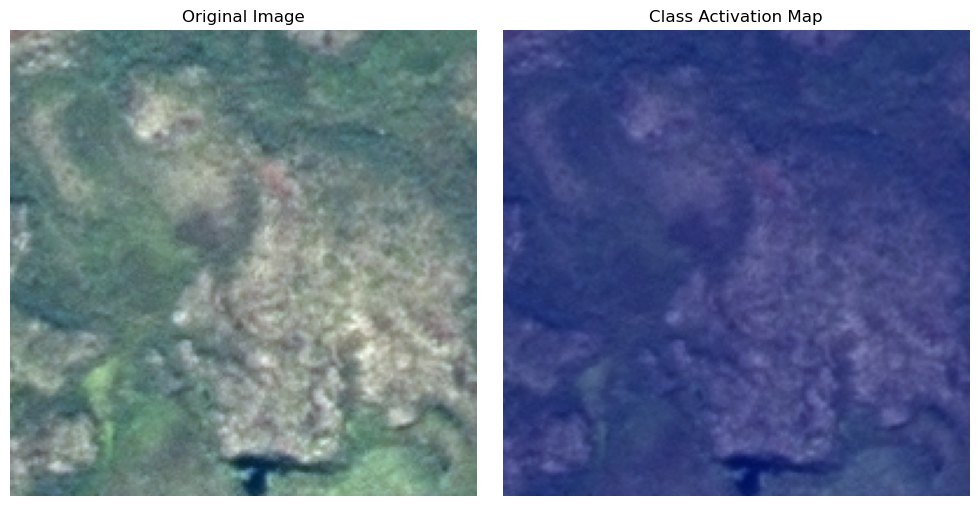

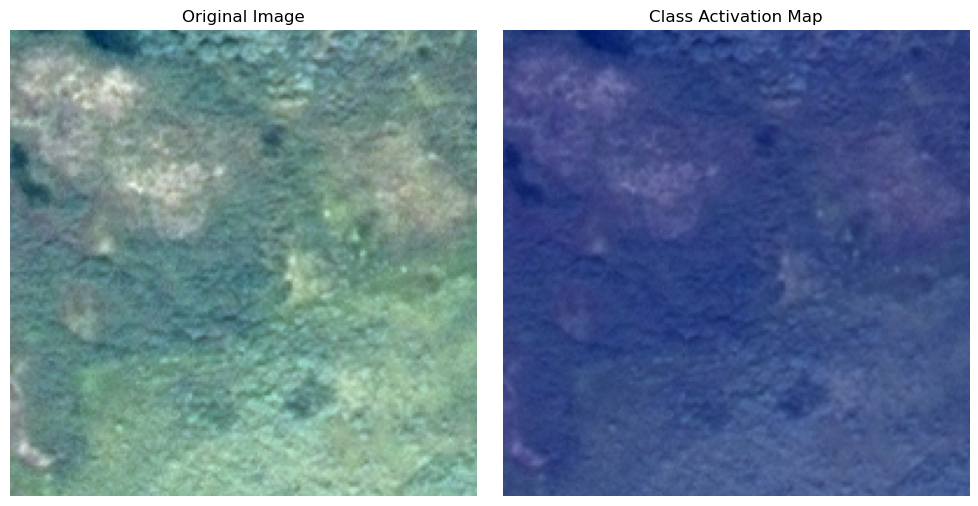

In [26]:
import matplotlib.pyplot as plt 

# Generate CAMs during inference
model.eval()
with torch.no_grad():
    for data, targets in val_loader:
        data, targets = data.to(device), targets.to(device)
        transformed_batch = transforms(data)

        # Get the feature maps before the final classifier
        features = model.features(transformed_batch)

        # Apply global average pooling
        pooled_features = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        pooled_features = pooled_features.view(pooled_features.size(0), -1)

        # Get the weights of the final classifier
        weights = model.classifier[0].weight.data
        weights = weights.transpose(0, 1)

        # Generate CAMs
        cams = torch.matmul(pooled_features, weights)
        cams = cams.view(cams.size(0), 2, 1, 1)  # Reshape to match the feature map dimensions

        # Upsample the CAMs to match the input image size
        cams = nn.functional.interpolate(cams, size=(200, 200), mode='bilinear', align_corners=True)

        # Normalize the CAMs
        cams = torch.max(cams, dim=1)[0]
        cams = (cams - cams.min()) / (cams.max() - cams.min())

        # Iterate over the batch
        for i in range(data.size(0)):
            # Get the original image
            image = data[i].cpu().numpy()
            image = np.transpose(image, (1, 2, 0))

            # Normalize the image for visualization
            image = (image - image.min()) / (image.max() - image.min())

            # Get the CAM for the permafrost class (assuming class index 1)
            cam = cams[i].cpu().numpy()

            # Create a figure with two subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

            # Display the original image
            ax1.imshow(image)
            ax1.set_title('Original Image')
            ax1.axis('off')

            # Display the CAM overlaid on the image
            ax2.imshow(image, cmap='gray')
            ax2.imshow(cam, cmap='jet', alpha=0.5)
            ax2.set_title('Class Activation Map')
            ax2.axis('off')

            # Display the figure
            plt.tight_layout()
            plt.show()

        break

        # Visualize the CAMs for the permafrost class (assuming class index 1)